# Part 1: Linear Image Classifier

In this notebook I will implement a linear image classifier while getting familiar with `numpy` and the benefits of vectorized operations in Python. This notebook has 2 parts:

1. Implementing loss functions, calculating gradients and implementing gradient descent.
2. Training and evaluating several classifiers.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy as np
import os
import sys
import urllib.request
import tarfile
import zipfile
from random import randrange
from functools import partial
import itertools
import time

# specify the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 3.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Data preprocessing


## Data download and processing

In [2]:
def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        print("Downloading, This might take several minutes.")
        last_update_time = time.time()
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path)

        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")
        print("If not, delete the dataset folder and try again.")

def load_CIFAR_batch(filename):
    ''' load single batch of cifar '''
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding = 'latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load(ROOT):
    ''' load all of cifar '''
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

## Data Download

The next cell will download and extract CIFAR-10 into `datasets/cifar10/`. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class.


In [3]:
# this cell will download the data if it does not exists
URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
PATH = 'datasets/cifar10/'     # the script will create required directories
maybe_download_and_extract(URL, PATH) 

Downloading, This might take several minutes.
Download finished. Extracting files.
Done.


## Data Preprocessing Part 1

Included arevseveral image processing functions. Notice the following in particular: there is an additional validation dataset you need to use for hyperparameter optimization.

In [4]:
CIFAR10_PATH = os.path.join(PATH, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load(CIFAR10_PATH) # load the entire data

# taking only two classes from the dataset
X_train = X_train[np.logical_or(y_train == 0, y_train == 1)]
y_train = y_train[np.logical_or(y_train == 0, y_train == 1)]
X_test = X_test[np.logical_or(y_test == 0, y_test == 1)]
y_test = y_test[np.logical_or(y_test == 0, y_test == 1)]

# define a splitting for the data
num_training = 10000
num_validation = 1000
num_testing = 1000

mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# portion from the test dataset a validation dataset for hyperparameter optimization
mask = range(num_validation)
X_val = X_test[mask]
y_val = y_test[mask]

# test dataset, without overlap with train/validation
mask = range(num_validation, num_validation+num_testing)
X_test = X_test[mask]
y_test = y_test[mask]

# float64
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)
X_test = X_test.astype(np.float64)

classes = ('plane', 'car')

      car	      car	    plane	      car


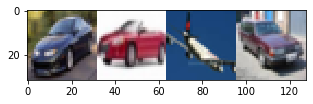

In [5]:
def get_batch(X, y, n=1000):
    rand_items = np.random.randint(0, X.shape[0], size=n)
    images = X[rand_items]
    labels = y[rand_items]
    return images, labels

def make_random_grid(x, y, n=4, convert_to_image=True, random_flag=True):
    if random_flag:
        rand_items = np.random.randint(0, x.shape[0], size=n)
    else:
        rand_items = np.arange(0, x.shape[0])
    images = x[rand_items]
    labels = y[rand_items]
    if convert_to_image:
        grid = np.hstack(np.array([np.asarray((vec_2_img(i) + mean_image), dtype=np.int64) for i in images]))
    else:
        grid = np.hstack(np.array([np.asarray(i, dtype=np.int64) for i in images]))
    print('\t'.join('%9s' % classes[labels[j]] for j in range(n)))
    return grid

def vec_2_img(x):
    x = np.reshape(x[:-1], (32, 32, 3))
    return x

X_batch, y_batch = get_batch(X_test, y_test, 100)
plt.imshow(make_random_grid(X_batch, y_batch, n=4, convert_to_image=False));

## Data Preprocessing Part 2

Included are several image processing functions. Notice the following in particular: the mean has been subtracted from all the images in order to ignore illumination conditions while keeping the content of the image. Next, the images are flattened from a tensor of shape (32x32x3) to a vector with 3072 features (pixel values) so we would be able to use a simple matrix multiplication. Finally, each image vector is concatenated with an additional feature to account for the bias. This is known as the bias trick. 

Make sure you understand this image processing pipeline before diving into the rest of the code.

In [6]:
# Final data preprocessing
# subtract the mean from all the images in the batch
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# flatten all the images in the batch (make sure you understand why this is needed)
X_train = np.reshape(X_train, newshape=(X_train.shape[0], -1))
X_val = np.reshape(X_val, newshape=(X_val.shape[0], -1)) 
X_test = np.reshape(X_test, newshape=(X_test.shape[0], -1)) 

# add a bias term to all images in the batch
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]) 
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]) 
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]) 

print(f"Shape of Training Set: {X_train.shape}")
print(f"Shape of Validation Set: {X_val.shape}")
print(f"Shape of Test Set: {X_test.shape}")

Shape of Training Set: (10000, 3073)
Shape of Validation Set: (1000, 3073)
Shape of Test Set: (1000, 3073)


# Linear classifier: mapping images to scores

During this exercise, we will maintain a python class with basic functionality (such as training the model). the linear classifiers we will build (perceptron, logistic regression) will inherit some functionality from that class and will change several functions (such as the loss function, for example). Read the code in the next cell and make sure you understand it. You might also find this [short classes in python tutorial](https://www.hackerearth.com/practice/python/object-oriented-programming/classes-and-objects-i/tutorial/) useful.


In [7]:
class LinearClassifier(object):
    def __init__(self, X, y):
        """
        Class constructor. Use this method to initiate the parameters of
        your model (W)
        *** Subclasses will override this. ***
        Inputs:
        - X: array of data
        - y: 1-dimensional array of length N with binary labels
        This function has no return value
        """
        pass

    def predict(self, X):
        """
        Use the weight of the classifier to predict a label. 
        *** Subclasses will override this. ***
        Input: 2D array of size (num_instances, num_features).
        Output: 1D array of class predictions (num_instances, 1). 
        """
        pass

    def calc_accuracy(self, X, y):
        """
        Calculate the accuracy on a dataset as the percentage of instances 
        that are classified correctly. 
        Inputs:
        - W: array of weights
        - X: array of data
        - y: 1-dimensional array of length N with binary labels
        Returns:
        - accuracy as a single float
        """
        accuracy = 0.0
        predictions = self.predict(X)
        accuracy = np.sum(predictions == y) / X.shape[0]
        return accuracy    

    def train(self, X, y, learning_rate=1e-3, num_iters=100, batch_size=200, verbose=False):
        #########################################################################
        # Sample batch_size elements from the training data and their           #
        # corresponding labels to use in every iteration.                       #
        # Store the data in X_batch and their corresponding labels in           #
        # y_batch                                                               #
        # replacement is faster than sampling without replacement.              #
        #                                                                       #
        # Next, calculate the loss and gradient and update the weights using    #
        # the learning rate. Use the loss_history array to save the loss on     #
        # iteration to visualize the loss.                                      #
        #########################################################################
        num_instances = X.shape[0]
        loss_history = []
        loss = 0.0
        for i in range(num_iters):
            
            ###########################################################################
            # Create X_batch and y_batch. Call the loss method to get the loss value  # 
            # and grad (the loss function is being override, see the loss             #
            # function return values).                                                #
            # Finally, append each of the loss values created in each iteration       #
            # to loss_history.                                                        #
            #                                                                         #
            # Perform parameter update                                                #
            # Update the weights using the gradient and the learning rate.            #
            ###########################################################################

            batch_indices = np.random.choice(X.shape[0], batch_size, replace=False)
            X_batch = X[batch_indices]
            y_batch = y[batch_indices].reshape(X_batch.shape[0],1)
            loss, grad = self.loss(X_batch, y_batch)
            grad = grad.reshape(X_batch.shape[1],1)
            loss_history.append(loss)
            self.W -= (learning_rate * grad)

            if verbose and i % 100 == 0:
                print ('iteration %d / %d: loss %f' % (i, num_iters, loss))

        return loss_history

    def loss(self, X, y):
        """
        Compute the loss function and its derivative. 
        ***Subclasses will override this.***
        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """ 
        pass

## Linear perceptron
Our first linear classifier will include a linear function that maps images to scores:

$$
f(x_i; W, b) = W\cdot x_i + b
$$

As you learned in class, this linear classifier takes an input image $x_i$ and outputs a class score. Your goal is to **learn** the parameters $W$ and $b$ to best classify the images according to the provided labels. The linear perceptron is set up so that the perceptron learn to map the correct class for each image such that it will have a score higher than the incorrect class.

Read the next code cell. The constructor of the `LinearPerceptron` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LinearPerceptron` class.

In [8]:
class LinearPerceptron(LinearClassifier):
    # Classifier that uses Perceptron loss

    def __init__(self, X, y):
        ###########################################################################
        # Initiate the parameters of your model.                                  #
        # You can assume y takes values 0...K-1 where K is number of classes      #
        ###########################################################################

        self.X = X
        self.y = y
        self.W = np.random.randn(3073, 1) * 0.0001 # Weight initiation seemed to have a major effect on performance
                                                   # using the normal distribution yeilded better results
                                                   # than initiating uniformly around (-1,1)

    def predict(self, X):

        y_pred = X @ self.W
        y_pred = y_pred.flatten()
        y_pred = np.where(y_pred<0, 0, 1)
        y_pred = y_pred.astype(int)
        return y_pred
        
    def loss(self, X_batch, y_batch):
        # perceptron_loss_vectorized will be implemented later
        return perceptron_loss_vectorized(self.W, X_batch, y_batch)

In [9]:
classifier = LinearPerceptron(X_train, y_train)
y_pred = classifier.predict(X_test)

    plane	      car	      car	      car


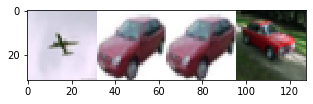

In [10]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch, convert_to_image=True))
plt.show()

In [11]:
# predictions
print(' '.join('%9s' % classes[y_pred[j]] for j in range(4)))

    plane       car     plane     plane


## Evaluation 

Complete the class method `calc_accuracy`.

In [12]:
print("model accuracy: ", classifier.calc_accuracy(X_train, y_train))

model accuracy:  0.5826


**Explain why the accuracy on the training dataset is around 50% (remember, the model is not trained yet). **(5 Points)**** 

Answer: 

Our objective is to classify images that have 2 possible lables : 'plane', 'car'.
In other words this is a binary classification problem.

One approach could be to look at the hypothesis space - assuming we generate an initial model that randomley sampled the infinite possibilities of hypothesis, then we should expect this classifier do be complelety random in its classification making the accuracy 50% since the problem is binary and the data is balanced.

Another approach could be to look at the Data - if we initialize an un biased and random model, we should expect our predictions to be uniformly distributed over the two posibillities.
In our case the decision boundry is 0 and our un-learned weights are initilaized as a gaussian with mean 0 making our predictions random with regard to positive or negative predictions. Therefore with a large number of attempts we should expect about half to be correct.

## Perceptron loss

Your code for this section will all be written in the next cell. In this section, we write and test code outside the classes for convenience. Notice the loss method for each class is just a call for the loss function written in the next cell. Once you are finished with implementation, everything should work.

First, complete the function `perceptron_loss_naive`. This function takes as input the weights, data, labels and outputs the calculated loss as a single number and the gradients with respect to W.  **(15 points)**

In [13]:
def perceptron_loss_naive(W, X, Y):
    """
    Structured perceptron loss function, naive implementation (with loops)
    Inputs:
    - W: array of weights
    - X: array of data
    - y: 1-dimensional array of length N with labels 0...K-1, for K classes
    Returns:
    a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    #############################################################################
    # Compute the perceptron loss as learned in class. Start by iterating over  #
    # over all instances and calculate the score and true score for each.       #
    # Now, for each class determine if the prediction is correct and update the #
    # loss over all mistakes.                                                   #
    # Compute the gradient of the loss function and store it as dW.             #
    # Rather that first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed.                                                   #
    #############################################################################

    y = np.copy(Y)  # Avoiding changing the origional validation or test labels
    y[y==0] = -1    # Reassigning labels to make the binary problem fit {-1,1} classes
    for i in range(X.shape[0]):
        z = X[i,:] @ W
        if ( y[i]*z < 0):
            loss += -y[i]*z
            dW += -y[i] * X[i,:].reshape(3073,1)
    loss = loss/X.shape[0]
    dW = dW / X.shape[0]
    return loss, dW

In [14]:
W = np.random.randn(3073, 1) * 0.0001

In [15]:
%%time
loss_naive, _ = perceptron_loss_naive(W, X_val, y_val)
print ('loss: %f' % (loss_naive))

loss: 0.076965
Wall time: 14 ms


Once your code works, complete the function `perceptron_loss_vectorized` and compare the results of the two functions using the cell below. 

In [16]:
def perceptron_loss_vectorized(W, X, Y):
    """
    Vectorized version of perceptron_loss_naive. instead of loops, should use 
    numpy vectorization.
    Inputs and outputs are the same as perceptron_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    #############################################################################
    # Implement a vectorized version of the perceptron loss, storing the        #
    # result in loss and the gradient in dW                                     #
    #############################################################################

    y = np.copy(Y)                # Avoiding changing the origional validation or test labels
    y = np.where(y==0, -1, y)     # Reassigning labels to make the binary problem fit {-1,1} classes
    y = y.reshape(X.shape[0],1)
    z_arr = X @ W                 # Current predictions over all X instances
    loss_arr = np.maximum(0, -y*z_arr)
    loss = np.sum(loss_arr) / X.shape[0]
    grad_mask = loss_arr
    grad_mask = np.where(grad_mask!=0, 1, 0)
    support_indices = y*grad_mask # Indices of incorrect predictions
    dW = -support_indices.T @ X / X.shape[0]
    return loss, dW.T

In [17]:
%%time
loss_vectorized, _ = perceptron_loss_vectorized(W, X_val, y_val)
print ('loss: %f' % (loss_vectorized))

loss: 0.076965
Wall time: 4.01 ms


You might not see big changes in time due to other computing factors. In big enough datasets it would be crucial to use the vectorized version.

We have obtained an efficient function for loss and gradient calculation and we can now train our network. Complete the function `train` in the `LinearClassifier` class.

In [18]:
%%time
perceptron = LinearPerceptron(X_train, y_train)
loss_history = perceptron.train(X_train, y_train, learning_rate=1e-7, 
                                num_iters=1500, verbose=True)

iteration 0 / 1500: loss 0.223364
iteration 100 / 1500: loss 0.028975
iteration 200 / 1500: loss 0.022543
iteration 300 / 1500: loss 0.021557
iteration 400 / 1500: loss 0.018115
iteration 500 / 1500: loss 0.015036
iteration 600 / 1500: loss 0.016021
iteration 700 / 1500: loss 0.019089
iteration 800 / 1500: loss 0.011486
iteration 900 / 1500: loss 0.020347
iteration 1000 / 1500: loss 0.011034
iteration 1100 / 1500: loss 0.010472
iteration 1200 / 1500: loss 0.009374
iteration 1300 / 1500: loss 0.012497
iteration 1400 / 1500: loss 0.012603
Wall time: 5.08 s


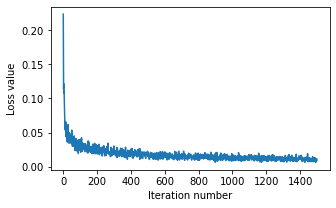

In [19]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [20]:
print("Training accuracy: ", perceptron.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", perceptron.calc_accuracy(X_test, y_test))

Training accuracy:  0.7737
Testing accuracy:  0.764


## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset. 

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations.


In [21]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6, 5e-3]
batch_sizes = [1, 100, 200, 250, 500]
results = {}
best_val = -1          # The highest validation accuracy that we have seen so far.
best_perceptron = None # The LinearPerceptron object that achieved the highest validation rate.


for lr in learning_rates:
    for bs in batch_sizes:
        perceptron = LinearPerceptron(X_train, y_train)
        perceptron.train(X_train, y_train, learning_rate=lr, num_iters=500, batch_size=bs, verbose=False) #500 iterations seems to yeild more accurate results
        training_accuracy = perceptron.calc_accuracy(X_train, y_train)
        validation_accuracy = perceptron.calc_accuracy(X_val, y_val)
        results[(lr,bs)] = (training_accuracy,validation_accuracy)
        if validation_accuracy > best_val :
            best_val = validation_accuracy
            best_perceptron = perceptron
    
# Print results
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_perceptron.calc_accuracy(X_test, y_test)
print ('linear perceptron on raw pixels final test set accuracy: %f' % test_accuracy)

lr 1.000000e-07 batch_size 1.000000e+00 train accuracy: 0.672000 val accuracy: 0.652000
lr 1.000000e-07 batch_size 1.000000e+02 train accuracy: 0.755200 val accuracy: 0.737000
lr 1.000000e-07 batch_size 2.000000e+02 train accuracy: 0.768800 val accuracy: 0.762000
lr 1.000000e-07 batch_size 2.500000e+02 train accuracy: 0.767300 val accuracy: 0.770000
lr 1.000000e-07 batch_size 5.000000e+02 train accuracy: 0.757300 val accuracy: 0.755000
lr 5.000000e-06 batch_size 1.000000e+00 train accuracy: 0.759400 val accuracy: 0.763000
lr 5.000000e-06 batch_size 1.000000e+02 train accuracy: 0.811100 val accuracy: 0.828000
lr 5.000000e-06 batch_size 2.000000e+02 train accuracy: 0.639500 val accuracy: 0.639000
lr 5.000000e-06 batch_size 2.500000e+02 train accuracy: 0.748500 val accuracy: 0.764000
lr 5.000000e-06 batch_size 5.000000e+02 train accuracy: 0.768500 val accuracy: 0.766000
lr 5.000000e-03 batch_size 1.000000e+00 train accuracy: 0.717100 val accuracy: 0.722000
lr 5.000000e-03 batch_size 1.000

## Logistic regression

Another choice for a binary classifier is the binary logistic regression classifier. Unlike the perceptron which treats the outputs as uncalibrated and possibly difficult to interpret scores for each class, the binary logistic regression classifier gives a slightly more intuitive output in the form of normalized class probabilities. In this classifier, the function mapping $f(x_i; W, b) = W\cdot x_i + b$ stays unchanged but we now interpret these scores as the unnormalized log probabilities for each class and replace the perceptron loss with a cross-entropy loss. In this exercise, we will define our binary logistic regression classifier to have one input.       

Read the next code cell. The constructor of the `LogisticRegression` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LogisticRegression` class - remember you need to implement the sigmoid function before you can obtain predictions using your classifier.

**Important note**: values passed to the `sigmoid` function can be arbitrarily large or small. When we take the exponent of such values, we might encounter extreme values that might *overflow*. This is known as numerical instability and you should always take care when you use exponent in your functions. 

In [22]:
def sigmoid(x):
    """
    Numerically stable Sigmoid function.
    Input: any unnormalized log probabilities vector
    Output: normalized probabilities
    """
    return np.where(x >= 0, 1/(1 + np.exp(-x)), np.exp(x)/(1 + np.exp(x)))
    

In [23]:
class LogisticRegression(LinearClassifier):
    # Classifer that uses sigmoid and binary cross entropy loss
    def __init__(self, X, y):

        self.X = X
        self.y = y
        self.W = np.random.randn(3073, 1) * 0.0001
        
    def predict(self, X):

        z = X @ self.W
        y_pred = sigmoid(z)
        y_pred = y_pred.flatten()
        y_pred = np.where(y_pred<0.5, 0, 1)
        y_pred = y_pred.astype(int)
        return y_pred

    def loss(self, X_batch, y_batch):
        # will be implemented later
        return binary_cross_entropy(self.W, X_batch, y_batch)

In [24]:
logistic = LogisticRegression(X_train, y_train)
y_pred = logistic.predict(X_test)

      car	    plane	    plane	      car


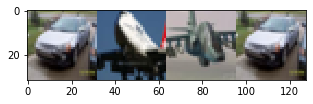

In [25]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

In [26]:
# predictions
print(' '.join('%13s' % classes[y_pred[j]] for j in range(4)))

          car         plane           car           car


In [27]:
print("model accuracy: ", logistic.calc_accuracy(X_train, y_train))

model accuracy:  0.4991


## Binary cross-entropy

Your code for this section will written in the next cell. 

Complete the function `binary_cross_entropy` using vectorized code. This function takes as input the weights, data, labels and outputs the calculated loss as a single number and the gradients with respect to W.

In [28]:
def binary_cross_entropy(W, X, Y):
    """
    Structured BCE loss function. Implement this function using vectorized code.
    Inputs:
    - W: array of weights
    - X: array of data
    - y: 1-dimensional array of length N with binary labels (0,1). 
    Returns:
    a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    #############################################################################
    # Implement the function and store result in loss and the gradint in dW     #
    # Note: in class you defined BCE that takes values from the range (-1,1).   #
    # and the sigmoid function generally outputs values in the range (0,1).     #
    # Make the proper adjustments for your code to work.                        #
    #############################################################################
    
    y = np.copy(Y)
    y = np.where(y==0, -1, y)
    y = y.reshape(X.shape[0],1)
    z = X @ W
    yz = y*z 
    loss = np.sum(np.log(1+ np.exp(-yz))) / X.shape[0]
    dW = ((-sigmoid(-yz) * y).T @ X) / X.shape[0]
    return loss, dW.T

In [29]:
W = np.random.randn(3073, 1) * 0.0001

In [30]:
%%time
loss_naive, grad_naive = binary_cross_entropy(W, X_val, y_val)
print ('loss: %f' % (loss_naive, ))

loss: 0.755251
Wall time: 5.03 ms


You are provided with a gradient test in the next cells:

In [31]:
def grad_check(f, x, analytic_grad, num_checks=10, h=1e-5):
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x)        # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x)        # evaluate f(x - h)
        x[ix] = oldval     # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print ('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [32]:
loss, grad = binary_cross_entropy(W, X_val, y_val)
f = lambda w: binary_cross_entropy(w, X_val, y_val)[0]
grad_numerical = grad_check(f, W, grad)

numerical: 9.766703 analytic: 9.766702, relative error: 4.300794e-09
numerical: 11.250448 analytic: 11.250448, relative error: 1.214698e-09
numerical: 7.176666 analytic: 7.176666, relative error: 1.252975e-08
numerical: 14.902666 analytic: 14.902666, relative error: 4.173698e-09
numerical: 9.738191 analytic: 9.738191, relative error: 1.177223e-09
numerical: 11.321352 analytic: 11.321352, relative error: 5.313597e-09
numerical: 0.952635 analytic: 0.952635, relative error: 2.364557e-08
numerical: 4.529496 analytic: 4.529497, relative error: 1.272376e-08
numerical: 5.184897 analytic: 5.184897, relative error: 3.518185e-09
numerical: -0.790128 analytic: -0.790128, relative error: 3.227548e-08


If implemented correctly, the training procedure you already implemented should work.

In [33]:
%%time
logistic = LogisticRegression(X_train, y_train)
loss_history = logistic.train(X_train, y_train, 
                         learning_rate=1e-7,
                         num_iters=1500,
                         verbose=True)

iteration 0 / 1500: loss 0.749614
iteration 100 / 1500: loss 0.503969
iteration 200 / 1500: loss 0.461387
iteration 300 / 1500: loss 0.440580
iteration 400 / 1500: loss 0.378265
iteration 500 / 1500: loss 0.423275
iteration 600 / 1500: loss 0.493315
iteration 700 / 1500: loss 0.454368
iteration 800 / 1500: loss 0.527222
iteration 900 / 1500: loss 0.445177
iteration 1000 / 1500: loss 0.485084
iteration 1100 / 1500: loss 0.399936
iteration 1200 / 1500: loss 0.424177
iteration 1300 / 1500: loss 0.427659
iteration 1400 / 1500: loss 0.367124
Wall time: 4.88 s


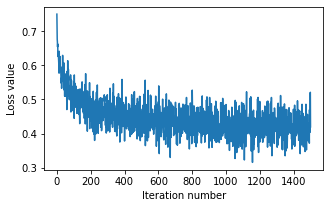

In [34]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [35]:
print("Training accuracy: ", logistic.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", logistic.calc_accuracy(X_test, y_test))

Training accuracy:  0.8136
Testing accuracy:  0.824


## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset. 

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations.

In [36]:
learning_rates = [1e-7, 5e-6]
batch_sizes = [1, 100, 200, 500]
results = {}
best_val = -1          # The highest validation accuracy that we have seen so far.
best_logistic = None   # The LogisticRegression object that achieved the highest validation rate.


for lr in learning_rates:
    for bs in batch_sizes:
        logistic = LogisticRegression(X_train, y_train)
        logistic.train(X_train, y_train, learning_rate=lr, num_iters=500, batch_size=bs, verbose=False)
        training_accuracy = logistic.calc_accuracy(X_train, y_train)
        validation_accuracy = logistic.calc_accuracy(X_val, y_val)
        results[(lr,bs)] = (training_accuracy,validation_accuracy)
        if validation_accuracy > best_val :
            best_val = validation_accuracy
            best_logistic = logistic

    
# Print results
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_logistic.calc_accuracy(X_test, y_test)
print ('Binary logistic regression on raw pixels final test set accuracy: %f' % test_accuracy)

lr 1.000000e-07 batch_size 1.000000e+00 train accuracy: 0.780200 val accuracy: 0.791000
lr 1.000000e-07 batch_size 1.000000e+02 train accuracy: 0.802400 val accuracy: 0.808000
lr 1.000000e-07 batch_size 2.000000e+02 train accuracy: 0.803000 val accuracy: 0.810000
lr 1.000000e-07 batch_size 5.000000e+02 train accuracy: 0.801300 val accuracy: 0.816000
lr 5.000000e-06 batch_size 1.000000e+00 train accuracy: 0.770800 val accuracy: 0.796000
lr 5.000000e-06 batch_size 1.000000e+02 train accuracy: 0.742500 val accuracy: 0.743000
lr 5.000000e-06 batch_size 2.000000e+02 train accuracy: 0.824900 val accuracy: 0.827000
lr 5.000000e-06 batch_size 5.000000e+02 train accuracy: 0.795700 val accuracy: 0.796000
best validation accuracy achieved during cross-validation: 0.827000
Binary logistic regression on raw pixels final test set accuracy: 0.831000


Attempt to visualize the final weights, remark that this predicts both cars and planes.

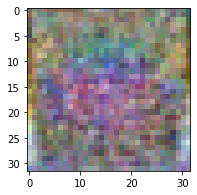

In [37]:
W = best_logistic.W
w_max = W.max()
w_min = W.min()
r = w_max-w_min
W = (W-w_min)*255/r
grid = np.hstack(np.array([np.asarray((vec_2_img(W)), dtype=np.int64)])) 
plt.imshow(grid)

# The End!